In [1]:
import itertools
# 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
# 
from cryptocmd import CmcScraper
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
# parameters
num_class = 5
split_date = '2023-04-01'
random_state=42

In [3]:
# daily data download
# https://github.com/guptarohit/cryptoCMD
# http://webcache.googleusercontent.com/search?q=cache:https://medium.com/geekculture/3-simple-ways-to-obtain-cryptocurrency-data-in-python-f45b9d603a97&strip=0&vwsrc=1&referer=medium-parser
scraper = CmcScraper("BTC")# Pandas dataFrame for the same data
df = scraper.get_dataframe()
df.drop(columns=['Time Open', 'Time High', 'Time Low', 'Time Close'], inplace=True)
df.sort_values(by=['Date'],inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Date,Open,High,Low,Close,Volume,Market Cap
0,2013-04-28,136.689455,143.365942,110.845593,127.954255,2.595684e+04,1.419008e+09
1,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09
2,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09
3,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09
4,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168517e+09
...,...,...,...,...,...,...,...
4027,2024-05-07,63162.763399,64390.456741,62285.979181,62334.818346,2.593073e+10,1.227660e+12
4028,2024-05-08,62332.642508,62986.084242,60877.127524,61187.941401,2.608817e+10,1.205202e+12
4029,2024-05-09,61191.200531,63404.915301,60648.075424,63049.959257,2.545334e+10,1.241942e+12
4030,2024-05-10,63055.190995,63446.742515,60208.781547,60792.776791,2.780495e+10,1.197421e+12


In [4]:
# Feature Engineering (on Returns, not on Price)
df['Volume'] = df['Volume'].replace(0, pd.NA)
df['Volume'] = df['Volume'].fillna(method='ffill')
# returns for Features (no look-ahead bias):
df['Rp'] = df['Close'].pct_change()
df['Rv'] = df['Volume'].pct_change()
# 
ema_14_rp = df.ta.ema(length=14, close='Rp')
rsi_14_rp = df.ta.rsi(length=14, close='Rp')
ema_14_rv = df.ta.ema(length=14, close='Rv')
rsi_14_rv = df.ta.rsi(length=14, close='Rv')
emsd_rp = df['Rp'] - ema_14_rp
emsd_rv = df['Rv'] - ema_14_rv
# Assign the resulting columns to the DataFrame with desired names
df['Rp_ema_14'] = ema_14_rp
df['Rp_rsi_14'] = rsi_14_rp
df['Rv_ema_14'] = ema_14_rv
df['Rv_rsi_14'] = rsi_14_rv
df['EMSD_Rp'] = emsd_rp
df['EMSD_Rv'] = emsd_rv
# target
df['Rp'] = df['Close'].pct_change().shift(-1)
# 
df

,Date,Open,High,Low,Close,Volume,Market Cap,Rp,Rv,Rp_ema_14,Rp_rsi_14,Rv_ema_14,Rv_rsi_14,EMSD_Rp,EMSD_Rv
0,2013-04-28,136.689455,143.365942,110.845593,127.954255,2.595684e+04,1.419008e+09,0.129622,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-04-29,134.444000,147.488007,134.000000,144.539993,2.595684e+04,1.603769e+09,-0.038328,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-04-30,144.000000,146.929993,134.050003,139.000000,2.595684e+04,1.542813e+09,-0.158345,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-05-01,139.000000,139.889999,107.720001,116.989998,2.595684e+04,1.298955e+09,-0.100692,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-05-02,116.379997,125.599998,92.281898,105.209999,2.595684e+04,1.168517e+09,-0.070906,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,2024-05-07,63162.763399,64390.456741,62285.979181,62334.818346,2.593073e+10,1.227660e+12,-0.018399,-0.096425,-0.001097,48.490079,0.037776,48.674160,-0.011999,-0.134201
4028,2024-05-08,62332.642508,62986.084242,60877.127524,61187.941401,2.608817e+10,1.205202e+12,0.030431,0.006072,-0.003403,47.839111,0.033549,49.696806,-0.014995,-0.027477
4029,2024-05-09,61191.200531,63404.915301,60648.075424,63049.959257,2.545334e+10,1.241942e+12,-0.035800,-0.024334,0.001108,53.966915,0.025831,49.382471,0.029323,-0.050165
4030,2024-05-10,63055.190995,63446.742515,60208.781547,60792.776791,2.780495e+10,1.197421e+12,0.000015,0.092389,-0.003813,46.062515,0.034705,50.672330,-0.031987,0.057684


In [5]:
# training quantiles training
features = ['Rp_ema_14','Rp_rsi_14','EMSD_Rp','Rv_ema_14','Rv_rsi_14','EMSD_Rv']
target = 'Rp'
df.dropna(inplace=True)
train_df = df.loc[df.Date < split_date]
test_df = df.loc[df.Date >= split_date]
X_train = train_df[features].values
y_train = train_df[target].values
X_test = test_df[features].values
y_test = test_df[target].values
# scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_quantiles = pd.qcut(y_train, q=num_class, labels=False)

In [6]:
# class prediction
xgb_classifier = XGBClassifier(objective='multi:softmax', num_class=num_class, random_state=random_state)
xgb_classifier.fit(X_train_scaled, y_train_quantiles)
# Predict classes for the test sample
y_train_test = xgb_classifier.predict(X_train_scaled)
y_pred_test = xgb_classifier.predict(X_test_scaled)
y_pred_all = np.concatenate((y_train_test, y_pred_test))
df['Predicted_Class'] = y_pred_all
df

,Date,Open,High,Low,Close,Volume,Market Cap,Rp,Rv,Rp_ema_14,Rp_rsi_14,Rv_ema_14,Rv_rsi_14,EMSD_Rp,EMSD_Rv,Predicted_Class
243,2013-12-27,763.280029,777.510010,713.599976,735.070007,4.686270e+07,8.955395e+09,-0.009849,1804.408517,0.011256,48.707992,240.587802,100.000000,-0.046572,1563.820714,1
244,2013-12-28,737.979980,747.059998,705.349976,727.830017,3.250580e+07,8.869919e+09,0.023659,-0.306361,0.008442,49.452632,208.468580,48.143910,-0.018291,-208.774941,4
245,2013-12-29,728.049988,748.609985,714.440002,745.049988,1.901130e+07,9.082104e+09,0.014872,-0.415141,0.010471,50.471518,180.617418,48.142289,0.013189,-181.032559,3
246,2013-12-30,741.349976,766.599976,740.239990,756.130005,2.070770e+07,9.217168e+09,-0.002804,0.089231,0.011058,50.185815,156.546993,48.151004,0.003814,-156.457762,2
247,2013-12-31,760.320007,760.580017,738.169983,754.010010,2.089730e+07,9.191325e+09,0.023063,0.009156,0.009209,49.577921,135.675281,48.149620,-0.012013,-135.666125,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,2024-05-06,64038.313555,65494.901725,62746.238455,63161.950258,2.869793e+10,1.243985e+12,-0.013095,0.568522,0.000749,48.431230,0.058422,55.467104,-0.014324,0.510099,1
4027,2024-05-07,63162.763399,64390.456741,62285.979181,62334.818346,2.593073e+10,1.227660e+12,-0.018399,-0.096425,-0.001097,48.490079,0.037776,48.674160,-0.011999,-0.134201,1
4028,2024-05-08,62332.642508,62986.084242,60877.127524,61187.941401,2.608817e+10,1.205202e+12,0.030431,0.006072,-0.003403,47.839111,0.033549,49.696806,-0.014995,-0.027477,3
4029,2024-05-09,61191.200531,63404.915301,60648.075424,63049.959257,2.545334e+10,1.241942e+12,-0.035800,-0.024334,0.001108,53.966915,0.025831,49.382471,0.029323,-0.050165,4


In [7]:
# returns profile
conditions = [df['Predicted_Class'].isin([0,1,2,3,4]) # long
              , df['Predicted_Class'].isin([0,1,2,3,4]) # short
              ]
signals = [1
           , -1]
# Create the "signal" column using np.select
df['signal'] = np.select(conditions, signals, default=0)
df['returns'] = df['signal']*df['Rp']
# Returns IS
df['cum_returns'] = (df['returns'] + 1).cumprod()
# sharpe ratios
std_dev = df['returns'].std()*np.sqrt(252)
ar = df['returns'].cumsum().iloc[-1]/((len(df)+1)/365.2)
sharpe_ratio = ar / std_dev
print("sharpe_ratio IS:",sharpe_ratio)
# Returns OOS
test_df = df.loc[df.Date >= split_date].copy()
test_df['cum_returns'] = (test_df['returns'] + 1).cumprod()
# sharpe ratios
std_dev = test_df['returns'].std()*np.sqrt(252)
ar = test_df['returns'].cumsum().iloc[-1]/((len(test_df)+1)/365.2)
sharpe_ratio = ar / std_dev
print("sharpe_ratio OOS:",sharpe_ratio)

sharpe_ratio IS: 1.1537328231580428
sharpe_ratio OOS: 2.0486345377438164


In [8]:
all_classes = list(range(num_class))
# Initialize a DataFrame to store the Sharpe ratios for each combination
sharpe_ratios_df = []
# Generate all possible combinations of long and short classes
for subset_length in range(num_class + 1):
    for long_classes in itertools.combinations(all_classes, r=subset_length):
        print(long_classes)
        short_classes = [item for item in all_classes if item not in long_classes]
        # Filter data based on the long and short classes
        long_condition = df['Predicted_Class'].isin(long_classes)
        short_condition = df['Predicted_Class'].isin(short_classes)
        df['signal'] = np.select([long_condition, short_condition], [1, -1], default=0)
        # Calculate returns
        df['returns'] = df['signal'] * df['Rp']
        # Calculate cumulative returns
        df['cum_returns'] = (df['returns'] + 1).cumprod()
        # Calculate Sharpe ratio for in-sample data
        std_dev_is = df['returns'].std() * np.sqrt(252)
        ar_is = df['returns'].cumsum().iloc[-1] / ((len(df) + 1) / 365.2)
        sharpe_ratio_is = ar_is / std_dev_is
        # Filter test data based on split_date
        test_df = df.loc[df.Date >= split_date].copy()
        # Calculate Sharpe ratio for out-of-sample data
        std_dev_oos = test_df['returns'].std() * np.sqrt(252)
        ar_oos = test_df['returns'].cumsum().iloc[-1] / ((len(test_df) + 1) / 365.2)
        sharpe_ratio_oos = ar_oos / std_dev_oos
        # Append the Sharpe ratios to the DataFrame
        sharpe_ratios_df.append({'Long_Classes': long_classes,
                                                    'Short_Classes': short_classes,
                                                    'Sharpe_Ratio_IS': sharpe_ratio_is,
                                                    'Sharpe_Ratio_OOS': sharpe_ratio_oos
                                                    })
sharpe_ratios_df = pd.DataFrame(sharpe_ratios_df)

()
(0,)
(1,)
(2,)
(3,)
(4,)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 2)
(1, 3)
(1, 4)
(2, 3)
(2, 4)
(3, 4)
(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 2, 3)
(0, 2, 4)
(0, 3, 4)
(1, 2, 3)
(1, 2, 4)
(1, 3, 4)
(2, 3, 4)
(0, 1, 2, 3)
(0, 1, 2, 4)
(0, 1, 3, 4)
(0, 2, 3, 4)
(1, 2, 3, 4)
(0, 1, 2, 3, 4)


In [9]:
sharpe_ratios_df.sort_values(by=['Sharpe_Ratio_IS'], ascending=[False],inplace=True)
sharpe_ratios_df

,Long_Classes,Short_Classes,Sharpe_Ratio_IS,Sharpe_Ratio_OOS
25,"(2, 3, 4)","[0, 1]",17.028861,1.328510
15,"(3, 4)","[0, 1, 2]",16.069636,-0.257884
30,"(1, 2, 3, 4)",[0],13.355972,1.362290
24,"(1, 3, 4)","[0, 2]",12.579789,-0.224272
14,"(2, 4)","[0, 1, 3]",11.845648,-1.196581
5,"(4,)","[0, 1, 2, 3]",11.129135,-2.799762
23,"(1, 2, 4)","[0, 3]",9.017116,-1.162841
12,"(1, 4)","[0, 2, 3]",8.390033,-2.765410
29,"(0, 2, 3, 4)",[1],3.322252,2.014631
21,"(0, 3, 4)","[1, 2]",2.795563,0.422814


In [10]:
sharpe_ratios_df.sort_values(by=['Sharpe_Ratio_OOS'], ascending=[False],inplace=True)
sharpe_ratios_df

,Long_Classes,Short_Classes,Sharpe_Ratio_IS,Sharpe_Ratio_OOS
26,"(0, 1, 2, 3)",[4],-11.129135,2.799762
19,"(0, 2, 3)","[1, 4]",-8.390033,2.765410
22,"(1, 2, 3)","[0, 4]",0.379481,2.107347
13,"(2, 3)","[0, 1, 4]",2.530442,2.073320
31,"(0, 1, 2, 3, 4)",[],1.153733,2.048635
29,"(0, 2, 3, 4)",[1],3.322252,2.014631
30,"(1, 2, 3, 4)",[0],13.355972,1.362290
25,"(2, 3, 4)","[0, 1]",17.028861,1.328510
17,"(0, 1, 3)","[2, 4]",-11.845648,1.196581
8,"(0, 3)","[1, 2, 4]",-9.017116,1.162841


In [11]:
sharpe_ratios_df['Sharpe_Ratio_OOS'].corr(sharpe_ratios_df['Sharpe_Ratio_IS'])

-0.12015244417908937

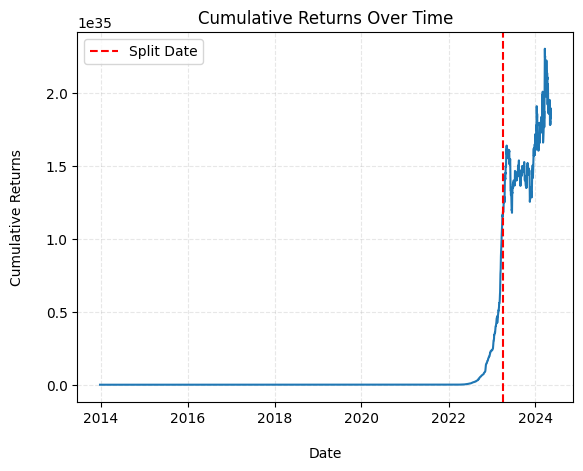

In [12]:
long_classes = [2,3,4]
short_classes = [item for item in all_classes if item not in long_classes]
# Filter data based on the long and short classes
long_condition = df['Predicted_Class'].isin(long_classes)
short_condition = df['Predicted_Class'].isin(short_classes)
df['signal'] = np.select([long_condition, short_condition], [1, -1], default=0)
# Calculate returns
df['returns'] = df['signal'] * df['Rp']
# Calculate cumulative returns
df['cum_returns'] = (df['returns'] + 1).cumprod()

# Plot the cumulative results
plt.plot(df['Date'],df['cum_returns'])
plt.xlabel('\nDate')
# plt.xticks(df['Date'], rotation=90)
plt.ylabel('Cumulative Returns\n')
plt.title('Cumulative Returns Over Time')
plt.grid(True,alpha=0.3,linestyle='--')
split_date = pd.to_datetime(split_date)
plt.axvline(x=split_date, color='r', linestyle='--', label='Split Date')
plt.legend()
plt.show()